In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
from tqdm.notebook import tqdm

In [2]:
#!pip install matplotlib

In [3]:
path = "./"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [4]:
!ls

20200508(1).ipynb   processed_data
20200508(2).ipynb   sales.csv
20200517(1).ipynb   sales_train_validation.csv
20200518(1).ipynb   sales_train_validation.csv.zip
20200518(2).ipynb   sample_submission.csv
20200519(1).ipynb   sample_submission.csv.zip
20200523(1).ipynb   sell_prices.csv
20200524(1).ipynb   sell_prices.csv.zip
20200525(1).ipynb   skhts
Untitled1.ipynb     submission.csv
VAR		    test_from_1858_till_1913.ipynb
calendar.csv	    test_from_1914_till_1969.ipynb
darkmagic	    train.bin
docker_command.txt  url.txt
model.txt	    valid_data_label.npz


In [5]:
#!apt-get install unzip

In [6]:
#!unzip sales_train_validation.csv.zip

In [7]:
#!unzip sample_submission.csv.zip

In [8]:
#!unzip sell_prices.csv.zip

In [9]:
from sklearn.preprocessing import OrdinalEncoder


def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_name_2", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_type_1"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    return df


'''
def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    
    to_ordinal = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    all_event_data = np.concatenate((df[to_ordinal[:2]].values, df[to_ordinal[2:]].values), axis=0)
    enc = OrdinalEncoder(dtype="int").fit(all_event_data)
    df[to_ordinal[:2]] = enc.transform(df[to_ordinal[:2]]) + 1
    df[to_ordinal[2:]] = enc.transform(df[to_ordinal[2:]]) + 1
    
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    return df
'''

'\ndef prep_calendar(df):\n    df = df.drop(["date", "weekday"], axis=1)\n    df = df.assign(d = df.d.str[2:].astype(int))\n    \n    to_ordinal = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"] \n    df[to_ordinal] = df[to_ordinal].fillna("1")\n    all_event_data = np.concatenate((df[to_ordinal[:2]].values, df[to_ordinal[2:]].values), axis=0)\n    enc = OrdinalEncoder(dtype="int").fit(all_event_data)\n    df[to_ordinal[:2]] = enc.transform(df[to_ordinal[:2]]) + 1\n    df[to_ordinal[2:]] = enc.transform(df[to_ordinal[2:]]) + 1\n    \n    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal\n    df[to_int8] = df[to_int8].astype("int8")\n    return df\n'

In [10]:
calendar = prep_calendar(calendar)

In [11]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    to_float32 = ["sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7"]
    df[to_float32] = df[to_float32].astype("float32")
         
    return df

selling_prices = prep_selling_prices(selling_prices)

In [12]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i+1) for i in range(drop_d-1)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"))

    return df

#sales = reshape_sales(sales, 1000)
sales = reshape_sales(sales)

In [13]:
ids = sales.columns[sales.columns.str.contains("id")]

In [14]:
#ids = ids[:1]
#ids = ids[:2]
#print(ids)

In [15]:
'''
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
  
    to_float32 = ['lag_t28', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 
                  'rolling_mean_t90', 'rolling_mean_t180', 'rolling_std_t7', 'rolling_std_t30']
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
 
    return df

sales = prep_sales(sales)
'''

'\ndef prep_sales(df):\n    df[\'lag_t28\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28))\n    df[\'rolling_mean_t7\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[\'rolling_mean_t30\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).mean())\n    df[\'rolling_mean_t60\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(60).mean())\n    df[\'rolling_mean_t90\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(90).mean())\n    df[\'rolling_mean_t180\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(180).mean())\n    df[\'rolling_std_t7\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).std())\n    df[\'rolling_std_t30\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).std())\n  \n    to_float32 = [\'lag_t28\', \'rolling_mean_t7\', \'rolling_mean_t30

In [16]:
'''
def prep_sales_ex(df, subid=None):
    new_col_01 = 'lag_t28_' + subid
    new_col_02 = 'rolling_mean_t7_' + subid
    new_col_03 = 'rolling_mean_t30_' + subid
    new_col_04 = 'rolling_mean_t60_' + subid
    new_col_05 = 'rolling_mean_t90_' + subid
    new_col_06 = 'rolling_mean_t180_' + subid
    new_col_07 = 'rolling_std_t7_' + subid
    new_col_08 = 'rolling_std_t30_' + subid
    #new_col_09 = 'rolling_std_t60_' + subid
    new_col_09 = 'rolling_mean_t14_' + subid
    df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28))
    df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    #df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).std())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std())
  
    to_float32 = [new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07, new_col_08, new_col_09]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_06]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)
'''

'\ndef prep_sales_ex(df, subid=None):\n    new_col_01 = \'lag_t28_\' + subid\n    new_col_02 = \'rolling_mean_t7_\' + subid\n    new_col_03 = \'rolling_mean_t30_\' + subid\n    new_col_04 = \'rolling_mean_t60_\' + subid\n    new_col_05 = \'rolling_mean_t90_\' + subid\n    new_col_06 = \'rolling_mean_t180_\' + subid\n    new_col_07 = \'rolling_std_t7_\' + subid\n    new_col_08 = \'rolling_std_t30_\' + subid\n    #new_col_09 = \'rolling_std_t60_\' + subid\n    new_col_09 = \'rolling_mean_t14_\' + subid\n    df[new_col_01] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28))\n    df[new_col_02] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[new_col_03] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).mean())\n    df[new_col_04] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(60).mean())\n    df[new_col_05] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).roll

In [17]:
'''
def prep_sales_ex(df, subid=None):
    #new_col_01 = 'lag_t7_' + subid
    #new_col_02 = 'lag_t14_' + subid
    #new_col_03 = 'lag_t21_' + subid
    new_col_04 = 'lag_t28_' + subid
    #new_col_05 = 'lag_t63_' + subid
    #new_col_06 = 'lag_t84_' + subid
    #new_col_07 = 'lag_t182_' + subid
    
    new_col_08 = 'rolling_mean_t7_' + subid
    new_col_09 = 'rolling_mean_t14_' + subid
    new_col_10 = 'rolling_mean_t21_' + subid
    new_col_11 = 'rolling_mean_t28_' + subid
    new_col_28 = 'rolling_mean_t35_' + subid
    new_col_29 = 'rolling_mean_t42_' + subid
    new_col_30 = 'rolling_mean_t49_' + subid
    new_col_31 = 'rolling_mean_t56_' + subid
    new_col_12 = 'rolling_mean_t63_' + subid
    new_col_13 = 'rolling_mean_t84_' + subid
    new_col_14 = 'rolling_mean_t182_' + subid
    new_col_27 = 'rolling_mean_t364_' + subid
    
    new_col_15 = 'rolling_std_t7_' + subid
    new_col_16 = 'rolling_std_t14_' + subid
    new_col_17 = 'rolling_std_t21_' + subid
    new_col_18 = 'rolling_std_t28_' + subid
    new_col_19 = 'rolling_std_t35_' + subid
    new_col_20 = 'rolling_std_t42_' + subid
    new_col_21 = 'rolling_std_t49_' + subid
    new_col_22 = 'rolling_std_t56_' + subid
    new_col_23 = 'rolling_std_t63_' + subid
    new_col_24 = 'rolling_std_t84_' + subid
    new_col_25 = 'rolling_std_t182_' + subid
    new_col_26 = 'rolling_std_t364_' + subid
    
    
    #df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7))
    #df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*2))
    #df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*3))
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*4))
    #df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*9))
    #df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*12))
    #df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*26))
    
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).mean())
    df[new_col_10] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*3).mean())
    df[new_col_11] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*4).mean())
    df[new_col_28] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*5).mean())
    df[new_col_29] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*6).mean())
    df[new_col_30] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*7).mean())
    df[new_col_31] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*8).mean())
    df[new_col_12] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*9).mean())
    df[new_col_13] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*12).mean())
    df[new_col_14] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26).mean())
    df[new_col_27] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26*2).mean())

    df[new_col_15] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_16] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std())
    df[new_col_17] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*3).std())
    df[new_col_18] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*4).std())
    df[new_col_19] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*5).std())
    df[new_col_20] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*6).std())
    df[new_col_21] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*7).std())
    df[new_col_22] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*8).std())
    df[new_col_23] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*9).std())
    df[new_col_24] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*12).std())
    df[new_col_25] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26).std())
    df[new_col_26] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26*2).std())
  
    to_float32 = [#new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07,
                  new_col_04,
                  new_col_08, new_col_09, new_col_10, new_col_11, new_col_28, new_col_29, new_col_30, new_col_31,
                  new_col_12, new_col_13, new_col_14, new_col_27,
                  new_col_15, new_col_16, new_col_17, new_col_18, new_col_19, new_col_20, new_col_21, new_col_22, new_col_23, new_col_24, new_col_25, new_col_26]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t182 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_26]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)
'''

'\ndef prep_sales_ex(df, subid=None):\n    #new_col_01 = \'lag_t7_\' + subid\n    #new_col_02 = \'lag_t14_\' + subid\n    #new_col_03 = \'lag_t21_\' + subid\n    new_col_04 = \'lag_t28_\' + subid\n    #new_col_05 = \'lag_t63_\' + subid\n    #new_col_06 = \'lag_t84_\' + subid\n    #new_col_07 = \'lag_t182_\' + subid\n    \n    new_col_08 = \'rolling_mean_t7_\' + subid\n    new_col_09 = \'rolling_mean_t14_\' + subid\n    new_col_10 = \'rolling_mean_t21_\' + subid\n    new_col_11 = \'rolling_mean_t28_\' + subid\n    new_col_28 = \'rolling_mean_t35_\' + subid\n    new_col_29 = \'rolling_mean_t42_\' + subid\n    new_col_30 = \'rolling_mean_t49_\' + subid\n    new_col_31 = \'rolling_mean_t56_\' + subid\n    new_col_12 = \'rolling_mean_t63_\' + subid\n    new_col_13 = \'rolling_mean_t84_\' + subid\n    new_col_14 = \'rolling_mean_t182_\' + subid\n    new_col_27 = \'rolling_mean_t364_\' + subid\n    \n    new_col_15 = \'rolling_std_t7_\' + subid\n    new_col_16 = \'rolling_std_t14_\' + subid\n

In [18]:
cols = ['lag_t28_',
        'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 'rolling_mean_t28_', 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_',
        'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 'rolling_std_t28_', 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_']

In [19]:
def prep_sales_ex(df, cols=None, subid=None):
    new_cols = [col+subid for col in cols]
    nums=[]
    for col in new_cols:
        if "mean" in col:
            num = int(col.split("_")[2][1:])
            #print("mean: ", num)
            df[col] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(num).mean())
            nums.append(num)
        elif "std" in col:
            num = int(col.split("_")[2][1:])
            #print("std: ", num)
            df[col] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(num).std())
            nums.append(num)
        else:
            num = int(col.split("_")[1][1:])
            #print("lag: ", num)
            df[col] = df.groupby([subid])['demand'].transform(lambda x: x.shift(num))
            nums.append(num)
  
    df[new_cols] = df[new_cols].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_xx_t{max} was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_cols[np.argmax(nums)]]))]
 
    return df


for subid in ids:
    sales = prep_sales_ex(sales, cols=cols, subid=subid)
#del ids

In [20]:
"""
def prep_sales_ex(df, subid=None):
    new_col_01 = 'lag_t28_' + subid
    
    new_col_02 = 'rolling_mean_t7_' + subid
    new_col_03 = 'rolling_mean_t14_' + subid
    new_col_04 = 'rolling_mean_t21_' + subid
    new_col_05 = 'rolling_mean_t28_' + subid
    new_col_06 = 'rolling_mean_t63_' + subid
    new_col_07 = 'rolling_mean_t84_' + subid
    new_col_08 = 'rolling_mean_t182_' + subid
    
    new_col_09 = 'rolling_std_t7_' + subid
    new_col_10 = 'rolling_std_t14_' + subid
    new_col_11 = 'rolling_std_t21_' + subid
    new_col_12 = 'rolling_std_t28_' + subid
    new_col_13 = 'rolling_std_t63_' + subid
    new_col_14 = 'rolling_std_t84_' + subid
    new_col_15 = 'rolling_std_t182_' + subid
    
    
    df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28))
    
    df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(14).mean())
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(21).mean())
    df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(28).mean())
    df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(63).mean())
    df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(84).mean())
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(182).mean())
    
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_10] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(14).std())
    df[new_col_11] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(21).std())
    df[new_col_12] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(28).std())
    df[new_col_13] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(63).std())
    df[new_col_14] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(84).std())
    df[new_col_15] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(182).std())
  
    to_float32 = [new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07, new_col_08,
                  new_col_09, new_col_10, new_col_11, ]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_06]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)
"""

'\ndef prep_sales_ex(df, subid=None):\n    new_col_01 = \'lag_t28_\' + subid\n    \n    new_col_02 = \'rolling_mean_t7_\' + subid\n    new_col_03 = \'rolling_mean_t14_\' + subid\n    new_col_04 = \'rolling_mean_t21_\' + subid\n    new_col_05 = \'rolling_mean_t28_\' + subid\n    new_col_06 = \'rolling_mean_t63_\' + subid\n    new_col_07 = \'rolling_mean_t84_\' + subid\n    new_col_08 = \'rolling_mean_t182_\' + subid\n    \n    new_col_09 = \'rolling_std_t7_\' + subid\n    new_col_10 = \'rolling_std_t14_\' + subid\n    new_col_11 = \'rolling_std_t21_\' + subid\n    new_col_12 = \'rolling_std_t28_\' + subid\n    new_col_13 = \'rolling_std_t63_\' + subid\n    new_col_14 = \'rolling_std_t84_\' + subid\n    new_col_15 = \'rolling_std_t182_\' + subid\n    \n    \n    df[new_col_01] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28))\n    \n    df[new_col_02] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[new_col_03] = df.groupby([su

In [21]:
# d >= 1914 has no demand (1914 <= d < 1941: validation, d >= 1941: test)
#sales[sales["demand"].isnull()]["d"].unique()

In [22]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
del calendar

In [23]:
sales = sales.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
del selling_prices

In [24]:
#for i, v in tqdm(enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"])):
for i, v in enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"]):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]]).astype("int16") + 1
gc.collect()

22

In [ ]:
sales.to_csv("sales_20200525(1).csv")

In [35]:
# Start from here from next time
#sales = pd.read_csv("sales_20200525(1).csv")

In [36]:
"""
base_features = ['lag_t28_',
                 'rolling_mean_t7_', 'rolling_mean_t30_', 'rolling_mean_t60_', 'rolling_mean_t90_', 'rolling_mean_t180_', 
                 'rolling_std_t7_', 'rolling_std_t30_', 'rolling_std_t60_', 'rolling_std_t90_', 'rolling_std_t180_']
"""
extended_features = []
for subid in ids:
    tmp = [v+subid for v in cols]
    extended_features.extend(tmp)
del ids

In [38]:
# Covariables used
x = ["wday", "month", "year", 
     "event_name_1", "event_type_1",
     "snap_CA", "snap_TX", "snap_WI",
     "sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7",
     "item_id", "dept_id", "cat_id", "store_id", "state_id"]

In [39]:
#x.extend(base_features)

In [40]:
x.extend(extended_features)

In [43]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))

# Reduce sales
sales = sales[sales.d < 1914]
gc.collect()

110

In [45]:
# "F1" is assined to both d=1914 and 1942, for example
test[test.F == "F1"].d.unique()

array([1914, 1942])

In [46]:
# "F28" is assined to both d=1941 and 1969, for example
test[test.F == "F28"].d.unique()

array([1941, 1969])

In [47]:
import lightgbm as lgb

In [49]:
# One month of validation data
flag = sales.d >= 1914 - 28
valid = lgb.Dataset(sales[flag][x], label = sales[["demand"]][flag])
#np.savez('valid_data_label', data=sales[flag][x], label=sales[["demand"]][flag])
gc.collect()

# Rest is used for training
sales = sales[~flag].drop(["d", "id"], axis=1)
del flag
gc.collect()
sales = lgb.Dataset(sales[x], label = sales[["demand"]])

# Trick to avoid memory spike when LightGBM converts everything to float32:
#   See https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
#sales.save_binary('train.bin')
#sales = lgb.Dataset('train.bin')

In [50]:

params = {
    'metric': 'rmse',
    'objective': 'poisson',
    'seed': 20,
    'learning_rate': 0.08,
    'lambda': 0.1,
    'num_leaves': 63*2,
    'bagging_fraction': 0.7,
    'bagging_freq': 1, 
    'colsample_bytree': 0.7
}
"""
params = {
    'metric': 'rmse',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'seed': 20,
    'learning_rate': 0.08,
    'lambda': 0.1,
    'num_leaves': 63,
    'bagging_fraction': 0.7,
    'bagging_freq': 1, 
    'colsample_bytree': 0.7
}
"""

fit = lgb.train(params, 
                sales, 
                num_boost_round = 2100, 
                valid_sets = [valid], 
                early_stopping_rounds = 400,
                verbose_eval = 100)

Training until validation scores don't improve for 400 rounds
[100]	valid_0's rmse: 2.19326
[200]	valid_0's rmse: 2.1688
[300]	valid_0's rmse: 2.15234
[400]	valid_0's rmse: 2.14069
[500]	valid_0's rmse: 2.1357
[600]	valid_0's rmse: 2.13154
[700]	valid_0's rmse: 2.12951
[800]	valid_0's rmse: 2.12795
[900]	valid_0's rmse: 2.1263
[1000]	valid_0's rmse: 2.1248
[1100]	valid_0's rmse: 2.12392
[1200]	valid_0's rmse: 2.12289
[1300]	valid_0's rmse: 2.12209
[1400]	valid_0's rmse: 2.11941
[1500]	valid_0's rmse: 2.11905
[1600]	valid_0's rmse: 2.11797
[1700]	valid_0's rmse: 2.11753
[1800]	valid_0's rmse: 2.11653
[1900]	valid_0's rmse: 2.11588
[2000]	valid_0's rmse: 2.11521
[2100]	valid_0's rmse: 2.11499
Did not meet early stopping. Best iteration is:
[2079]	valid_0's rmse: 2.11472


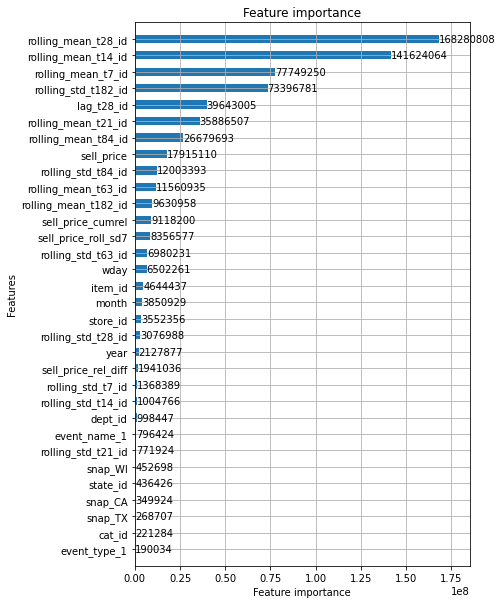

In [51]:
lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10))

In [52]:
# Validation & Visualization
'''

print('Saving model...')
# save model to file
fit.save_model('model.txt')

print('Loading model to predict...')
# load model to predict
fit = lgb.Booster(model_file='model.txt')


npz = np.load("./valid_data_label.npz")
valid_data = npz["data"]
#valid_data

valid_label = npz["label"]
#valid_label

pred = fit.predict(valid_data)

#plt.figure(14, 6)
plt.plot(range(28), valid_label[:28], color='blue')
plt.plot(range(28), pred[:28], color='red');
'''

'\n\nprint(\'Saving model...\')\n# save model to file\nfit.save_model(\'model.txt\')\n\nprint(\'Loading model to predict...\')\n# load model to predict\nfit = lgb.Booster(model_file=\'model.txt\')\n\n\nnpz = np.load("./valid_data_label.npz")\nvalid_data = npz["data"]\n#valid_data\n\nvalid_label = npz["label"]\n#valid_label\n\npred = fit.predict(valid_data)\n\n#plt.figure(14, 6)\nplt.plot(range(28), valid_label[:28], color=\'blue\')\nplt.plot(range(28), pred[:28], color=\'red\');\n'

In [53]:
pred = fit.predict(test[x])
pred

array([0.99361569, 0.38452902, 0.4668538 , ..., 0.08068375, 0.0922699 ,
       0.13425155])

In [54]:
pred.shape

(1707440,)

In [55]:
test.shape

(1707440, 36)

In [56]:
# The dark magic -> credits: https://www.kaggle.com/kyakovlev/m5-dark-magic
pred_calibrated = pred / pred[test["id"].str.endswith("validation")].mean() * 1.447147
pred_calibrated.shape

(1707440,)

In [57]:
#test["demand"] = pred
test["demand"] = pred_calibrated
test.shape

(1707440, 36)

In [58]:
test.F.unique()

array(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'],
      dtype=object)

In [59]:
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission.head()

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.151865,0.136024,0.138215,0.140423,0.159988,0.192946,0.179511,0.169512,0.136024,...,0.128901,0.167162,0.157102,0.129106,0.117746,0.119031,0.119363,0.136438,0.168206,0.146131
1,FOODS_1_001_CA_1_validation,0.791813,0.765673,0.800634,0.758550,1.040411,1.090485,1.008160,0.959629,0.897972,...,0.936417,1.251143,1.082249,0.987162,0.911105,0.885589,0.872803,1.013038,1.235027,1.092017
2,FOODS_1_001_CA_2_evaluation,0.135310,0.123728,0.125720,0.129538,0.149040,0.184909,0.169544,0.157091,0.123728,...,0.131238,0.174949,0.161708,0.125651,0.116989,0.118265,0.120036,0.139397,0.176040,0.150416
3,FOODS_1_001_CA_2_validation,0.800555,0.789272,0.775289,0.791455,0.895036,0.913256,0.543608,0.732737,0.801759,...,0.904434,0.928227,1.608027,0.896192,1.003271,0.996664,1.178997,1.158289,1.363491,1.561697
4,FOODS_1_001_CA_3_evaluation,0.265472,0.239270,0.240206,0.239751,0.261412,0.315328,0.300212,0.291369,0.239270,...,0.194519,0.265939,0.256209,0.219315,0.202117,0.201055,0.200208,0.219009,0.269188,0.242534


In [60]:
submission.to_csv("submission.csv", index=False)

In [61]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200505(2)" # df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std()) added

In [62]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200505(3)" 
''' with base_features = ['lag_t7_', 'lag_t14_', 'lag_t21_', 'lag_t28_', 'lag_t63_', 'lag_t84_', 'lag_t182_', 
                          'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 'rolling_mean_t28_', 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_',
                          'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 'rolling_std_t28_', 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_']
'''

" with base_features = ['lag_t7_', 'lag_t14_', 'lag_t21_', 'lag_t28_', 'lag_t63_', 'lag_t84_', 'lag_t182_', \n                          'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 'rolling_mean_t28_', 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_',\n                          'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 'rolling_std_t28_', 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_']\n"

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(1) remove from lag7 from lag182 but lag28"  # 0.54475

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(2) increase num of leaves from 63 to 63*2" # 0.54823

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(3) reduce learning rate from 0.08 to 0.04 and increase num boost round from 2100 to 4200" # 0.54979

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(1) add std35, std42, std49 and std56" # 0.54771

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(2) add std364" # 0.55362

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(3) add mean364" # 0.56688

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200508(1) add mean35" # 0.56041

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200508(2) add mean42, mean49 and mean56" # 0.55153

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200518(1) regressed to 20200506(1)" # 0.55230

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200518(2) didn't drop the first 1000 days" # 0.54526

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200519(1) Replaced poisson with tweedie for objective func" # 0.55238

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200523(1) Got poisson back for the objective and added event2's name and type" # 0.54526

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "Corrected: 20200523(1) Got poisson back for the objective and added event2's name and type" # 0.55161

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200524(1) event2's name and type dropped and rolling numbers set to be multiples of 7 (up to 182 for both mean and std)" # 0.54964 

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200525(1) Other levels () adopted as explanatory variables" # 